In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(369744, 828)
(369744, 1)
validation
(50536, 828)
(50536, 1)
test
(51136, 828)
(51136, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/37 [..............................] - ETA: 55s - loss: 0.0267 - STD: 2.1820e-04 - MAE: 0.1546

 4/37 [==>...........................] - ETA: 0s - loss: 0.0221 - STD: 2.4861e-04 - MAE: 0.1135 

 5/37 [===>..........................] - ETA: 1s - loss: 0.0213 - STD: 2.7998e-04 - MAE: 0.1084

 6/37 [===>..........................] - ETA: 1s - loss: 0.0197 - STD: 3.3266e-04 - MAE: 0.0997

 7/37 [====>.........................] - ETA: 1s - loss: 0.0184 - STD: 4.0080e-04 - MAE: 0.0952

 8/37 [=====>........................] - ETA: 1s - loss: 0.0178 - STD: 4.7450e-04 - MAE: 0.0956

 9/37 [======>.......................] - ETA: 1s - loss: 0.0176 - STD: 5.4608e-04 - MAE: 0.0975

10/37 [=======>......................] - ETA: 1s - loss: 0.0173 - STD: 6.1276e-04 - MAE: 0.0985

11/37 [=======>......................] - ETA: 1s - loss: 0.0168 - STD: 6.7286e-04 - MAE: 0.0977

12/37 [========>.....................] - ETA: 1s - loss: 0.0164 - STD: 7.2431e-04 - MAE: 0.0955

13/37 [=========>....................] - ETA: 3s - loss: 0.0159 - STD: 7.6621e-04 - MAE: 0.0925

16/37 [===========>..................] - ETA: 2s - loss: 0.0153 - STD: 8.7304e-04 - MAE: 0.0860

18/37 [=============>................] - ETA: 1s - loss: 0.0149 - STD: 9.5094e-04 - MAE: 0.0827

19/37 [==============>...............] - ETA: 1s - loss: 0.0147 - STD: 9.9631e-04 - MAE: 0.0814

20/37 [===============>..............] - ETA: 1s - loss: 0.0144 - STD: 0.0010 - MAE: 0.0805    

21/37 [================>.............] - ETA: 1s - loss: 0.0143 - STD: 0.0011 - MAE: 0.0801

22/37 [================>.............] - ETA: 1s - loss: 0.0141 - STD: 0.0012 - MAE: 0.0801

23/37 [=================>............] - ETA: 1s - loss: 0.0140 - STD: 0.0012 - MAE: 0.0802

24/37 [==================>...........] - ETA: 1s - loss: 0.0139 - STD: 0.0013 - MAE: 0.0802

25/37 [===================>..........] - ETA: 1s - loss: 0.0138 - STD: 0.0013 - MAE: 0.0801

26/37 [====================>.........] - ETA: 0s - loss: 0.0136 - STD: 0.0014 - MAE: 0.0797

27/37 [====================>.........] - ETA: 0s - loss: 0.0135 - STD: 0.0015 - MAE: 0.0791

28/37 [=====================>........] - ETA: 0s - loss: 0.0134 - STD: 0.0015 - MAE: 0.0783

29/37 [======================>.......] - ETA: 0s - loss: 0.0133 - STD: 0.0016 - MAE: 0.0775

30/37 [=======================>......] - ETA: 0s - loss: 0.0132 - STD: 0.0017 - MAE: 0.0767

31/37 [========================>.....] - ETA: 0s - loss: 0.0131 - STD: 0.0017 - MAE: 0.0760

32/37 [========================>.....] - ETA: 0s - loss: 0.0130 - STD: 0.0018 - MAE: 0.0754

33/37 [=========================>....] - ETA: 0s - loss: 0.0129 - STD: 0.0019 - MAE: 0.0748

34/37 [==========================>...] - ETA: 0s - loss: 0.0129 - STD: 0.0020 - MAE: 0.0744

35/37 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 0.0021 - MAE: 0.0741

36/37 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 0.0022 - MAE: 0.0739

37/37 [==============================] - ETA: 0s - loss: 0.0126 - STD: 0.0023 - MAE: 0.0738

37/37 [==============================] - 5s 96ms/step - loss: 0.0126 - STD: 0.0023 - MAE: 0.0738 - val_loss: 0.0135 - val_STD: 0.0062 - val_MAE: 0.0734


Epoch 2/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0098 - STD: 0.0075 - MAE: 0.0688

 2/37 [>.............................] - ETA: 2s - loss: 0.0097 - STD: 0.0078 - MAE: 0.0676

 3/37 [=>............................] - ETA: 2s - loss: 0.0097 - STD: 0.0081 - MAE: 0.0663

 4/37 [==>...........................] - ETA: 1s - loss: 0.0096 - STD: 0.0085 - MAE: 0.0647

 5/37 [===>..........................] - ETA: 1s - loss: 0.0095 - STD: 0.0089 - MAE: 0.0628

 6/37 [===>..........................] - ETA: 1s - loss: 0.0095 - STD: 0.0093 - MAE: 0.0614

 7/37 [====>.........................] - ETA: 1s - loss: 0.0095 - STD: 0.0098 - MAE: 0.0604

 8/37 [=====>........................] - ETA: 1s - loss: 0.0094 - STD: 0.0103 - MAE: 0.0595

 9/37 [======>.......................] - ETA: 1s - loss: 0.0093 - STD: 0.0109 - MAE: 0.0589

10/37 [=======>......................] - ETA: 1s - loss: 0.0092 - STD: 0.0116 - MAE: 0.0585

11/37 [=======>......................] - ETA: 1s - loss: 0.0091 - STD: 0.0124 - MAE: 0.0584

12/37 [========>.....................] - ETA: 1s - loss: 0.0090 - STD: 0.0132 - MAE: 0.0584

13/37 [=========>....................] - ETA: 1s - loss: 0.0089 - STD: 0.0142 - MAE: 0.0583

14/37 [==========>...................] - ETA: 1s - loss: 0.0088 - STD: 0.0152 - MAE: 0.0581

15/37 [===========>..................] - ETA: 1s - loss: 0.0087 - STD: 0.0162 - MAE: 0.0577

16/37 [===========>..................] - ETA: 1s - loss: 0.0085 - STD: 0.0173 - MAE: 0.0571

17/37 [============>.................] - ETA: 1s - loss: 0.0084 - STD: 0.0185 - MAE: 0.0564

18/37 [=============>................] - ETA: 1s - loss: 0.0083 - STD: 0.0198 - MAE: 0.0557

19/37 [==============>...............] - ETA: 1s - loss: 0.0081 - STD: 0.0211 - MAE: 0.0551

20/37 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.0226 - MAE: 0.0545

21/37 [================>.............] - ETA: 0s - loss: 0.0078 - STD: 0.0242 - MAE: 0.0540

22/37 [================>.............] - ETA: 0s - loss: 0.0077 - STD: 0.0260 - MAE: 0.0536

23/37 [=================>............] - ETA: 0s - loss: 0.0076 - STD: 0.0278 - MAE: 0.0531

24/37 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0296 - MAE: 0.0527

25/37 [===================>..........] - ETA: 0s - loss: 0.0073 - STD: 0.0313 - MAE: 0.0522

26/37 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.0330 - MAE: 0.0517

27/37 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.0347 - MAE: 0.0513

28/37 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0363 - MAE: 0.0509

29/37 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0379 - MAE: 0.0504

30/37 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0393 - MAE: 0.0499

31/37 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0407 - MAE: 0.0495

32/37 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0419 - MAE: 0.0490

33/37 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0430 - MAE: 0.0486

34/37 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0440 - MAE: 0.0482

35/37 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0450 - MAE: 0.0478

36/37 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0459 - MAE: 0.0474

37/37 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0470 - MAE: 0.0471

37/37 [==============================] - 2s 64ms/step - loss: 0.0060 - STD: 0.0470 - MAE: 0.0471 - val_loss: 0.0031 - val_STD: 0.0789 - val_MAE: 0.0345


Epoch 3/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0847 - MAE: 0.0336

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0849 - MAE: 0.0338

 3/37 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.0860 - MAE: 0.0338

 4/37 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.0864 - MAE: 0.0337

 5/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0874 - MAE: 0.0338

 6/37 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.0884 - MAE: 0.0338

 7/37 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.0889 - MAE: 0.0337

 8/37 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0893 - MAE: 0.0336

 9/37 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0894 - MAE: 0.0336

10/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0894 - MAE: 0.0336

11/37 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0892 - MAE: 0.0335

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0890 - MAE: 0.0335

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0886 - MAE: 0.0334

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0882 - MAE: 0.0334

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0880 - MAE: 0.0334

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0880 - MAE: 0.0334

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0879 - MAE: 0.0333

18/37 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0881 - MAE: 0.0333

19/37 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0882 - MAE: 0.0333

20/37 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.0882 - MAE: 0.0332

21/37 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0882 - MAE: 0.0332

22/37 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.0883 - MAE: 0.0332

23/37 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0884 - MAE: 0.0332

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0885 - MAE: 0.0332

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0885 - MAE: 0.0331

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0885 - MAE: 0.0331

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0884 - MAE: 0.0331

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0884 - MAE: 0.0331

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0883 - MAE: 0.0331

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0883 - MAE: 0.0331

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0883 - MAE: 0.0331

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0884 - MAE: 0.0331

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0884 - MAE: 0.0331

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0884 - MAE: 0.0330

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0885 - MAE: 0.0330

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0886 - MAE: 0.0330

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0886 - MAE: 0.0330

37/37 [==============================] - 2s 62ms/step - loss: 0.0027 - STD: 0.0886 - MAE: 0.0330 - val_loss: 0.0029 - val_STD: 0.0857 - val_MAE: 0.0328


Epoch 4/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0882 - MAE: 0.0328

 2/37 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.0891 - MAE: 0.0326

 3/37 [=>............................] - ETA: 1s - loss: 0.0026 - STD: 0.0899 - MAE: 0.0326

 4/37 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.0903 - MAE: 0.0325

 5/37 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.0907 - MAE: 0.0327

 6/37 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.0900 - MAE: 0.0325

 7/37 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0324

 8/37 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0323

 9/37 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0895 - MAE: 0.0324

10/37 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0323

11/37 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0894 - MAE: 0.0322

12/37 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0892 - MAE: 0.0323

13/37 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0893 - MAE: 0.0322

14/37 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0892 - MAE: 0.0322

15/37 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0892 - MAE: 0.0321

16/37 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0893 - MAE: 0.0321

17/37 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0894 - MAE: 0.0321

18/37 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0895 - MAE: 0.0321

19/37 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0321

20/37 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0321

21/37 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0321

22/37 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0321

23/37 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0321

24/37 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0321

25/37 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0321

26/37 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0895 - MAE: 0.0320

27/37 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0895 - MAE: 0.0320

28/37 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0320

29/37 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0320

30/37 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0320

31/37 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0320

32/37 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0320

33/37 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0320

34/37 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0320

35/37 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0320

36/37 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0320

37/37 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0320

37/37 [==============================] - 2s 62ms/step - loss: 0.0025 - STD: 0.0898 - MAE: 0.0320 - val_loss: 0.0028 - val_STD: 0.0861 - val_MAE: 0.0318


Epoch 5/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0895 - MAE: 0.0321

 2/37 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0894 - MAE: 0.0317

 3/37 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.0905 - MAE: 0.0313

 4/37 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0314

 5/37 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0910 - MAE: 0.0313

 6/37 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.0907 - MAE: 0.0315

 7/37 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0906 - MAE: 0.0314

 8/37 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0314

 9/37 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0908 - MAE: 0.0315

10/37 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0905 - MAE: 0.0314

11/37 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0903 - MAE: 0.0313

12/37 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0903 - MAE: 0.0313

13/37 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0901 - MAE: 0.0313

14/37 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0901 - MAE: 0.0313

15/37 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0900 - MAE: 0.0312

16/37 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0901 - MAE: 0.0312

17/37 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0902 - MAE: 0.0312

18/37 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0901 - MAE: 0.0312

19/37 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0901 - MAE: 0.0311

20/37 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0901 - MAE: 0.0311

21/37 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0903 - MAE: 0.0311

22/37 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0903 - MAE: 0.0311

23/37 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0903 - MAE: 0.0311

24/37 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0904 - MAE: 0.0311

25/37 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0905 - MAE: 0.0311

26/37 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0905 - MAE: 0.0311

27/37 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0905 - MAE: 0.0311

28/37 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0906 - MAE: 0.0311

29/37 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0906 - MAE: 0.0311

30/37 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0906 - MAE: 0.0311

31/37 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0906 - MAE: 0.0311

32/37 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0908 - MAE: 0.0311

33/37 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0908 - MAE: 0.0311

34/37 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0908 - MAE: 0.0311

35/37 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0908 - MAE: 0.0311

36/37 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0908 - MAE: 0.0310

37/37 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0908 - MAE: 0.0310

37/37 [==============================] - 2s 63ms/step - loss: 0.0023 - STD: 0.0908 - MAE: 0.0310 - val_loss: 0.0025 - val_STD: 0.0856 - val_MAE: 0.0302


Epoch 6/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0896 - MAE: 0.0307

 2/37 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0909 - MAE: 0.0305

 3/37 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0918 - MAE: 0.0304

 4/37 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.0918 - MAE: 0.0305

 5/37 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0921 - MAE: 0.0304

 6/37 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.0919 - MAE: 0.0305

 7/37 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0305

 8/37 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0304

 9/37 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0915 - MAE: 0.0303

10/37 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0913 - MAE: 0.0303

11/37 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0912 - MAE: 0.0302

12/37 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0913 - MAE: 0.0302

13/37 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0911 - MAE: 0.0302

14/37 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0912 - MAE: 0.0302

15/37 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0914 - MAE: 0.0302

16/37 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0302

17/37 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0913 - MAE: 0.0302

18/37 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0302

19/37 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0302

20/37 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0302

21/37 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0302

22/37 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0913 - MAE: 0.0302

23/37 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0913 - MAE: 0.0302

24/37 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0302

25/37 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0302

26/37 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0915 - MAE: 0.0302

27/37 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0301

28/37 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0301

29/37 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0301

30/37 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0301

31/37 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0915 - MAE: 0.0301

32/37 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0915 - MAE: 0.0301

33/37 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0915 - MAE: 0.0301

34/37 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0914 - MAE: 0.0300

35/37 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0914 - MAE: 0.0300

36/37 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0915 - MAE: 0.0300

37/37 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0915 - MAE: 0.0300

37/37 [==============================] - 2s 66ms/step - loss: 0.0021 - STD: 0.0915 - MAE: 0.0300 - val_loss: 0.0025 - val_STD: 0.0891 - val_MAE: 0.0303


Epoch 7/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0959 - MAE: 0.0297

 2/37 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.0941 - MAE: 0.0301

 3/37 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0951 - MAE: 0.0298

 4/37 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.0937 - MAE: 0.0298

 5/37 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.0938 - MAE: 0.0297

 6/37 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.0940 - MAE: 0.0298

 7/37 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.0926 - MAE: 0.0303

 8/37 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0931 - MAE: 0.0304

 9/37 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0931 - MAE: 0.0303

10/37 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0929 - MAE: 0.0303

11/37 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0934 - MAE: 0.0302

12/37 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0934 - MAE: 0.0301

13/37 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0929 - MAE: 0.0300

14/37 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0927 - MAE: 0.0300

15/37 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0927 - MAE: 0.0299

16/37 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0925 - MAE: 0.0299

17/37 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0926 - MAE: 0.0299

18/37 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0926 - MAE: 0.0298

19/37 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0925 - MAE: 0.0298

20/37 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.0927 - MAE: 0.0298

21/37 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0928 - MAE: 0.0298

22/37 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0926 - MAE: 0.0297

23/37 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0926 - MAE: 0.0297

24/37 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0925 - MAE: 0.0297

25/37 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0924 - MAE: 0.0297

26/37 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0925 - MAE: 0.0297

27/37 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0924 - MAE: 0.0297

28/37 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0923 - MAE: 0.0297

29/37 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0924 - MAE: 0.0297

30/37 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0298

31/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0923 - MAE: 0.0298

32/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0924 - MAE: 0.0297

33/37 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0923 - MAE: 0.0298

34/37 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0297

35/37 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0923 - MAE: 0.0297

36/37 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0298

37/37 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0297

37/37 [==============================] - 2s 61ms/step - loss: 0.0021 - STD: 0.0922 - MAE: 0.0297 - val_loss: 0.0027 - val_STD: 0.0915 - val_MAE: 0.0327


Epoch 8/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0966 - MAE: 0.0300

 2/37 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0934 - MAE: 0.0302

 3/37 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0932 - MAE: 0.0298

 4/37 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0938 - MAE: 0.0301

 5/37 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.0924 - MAE: 0.0304

 6/37 [===>..........................] - ETA: 1s - loss: 0.0021 - STD: 0.0926 - MAE: 0.0301

 7/37 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0934 - MAE: 0.0303

 8/37 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0924 - MAE: 0.0303

 9/37 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0924 - MAE: 0.0302

10/37 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0929 - MAE: 0.0303

11/37 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0924 - MAE: 0.0303

12/37 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0923 - MAE: 0.0302

13/37 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0929 - MAE: 0.0302

14/37 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0926 - MAE: 0.0302

15/37 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0926 - MAE: 0.0301

16/37 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0928 - MAE: 0.0301

17/37 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0929 - MAE: 0.0300

18/37 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0926 - MAE: 0.0300

19/37 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0928 - MAE: 0.0299

20/37 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.0929 - MAE: 0.0299

21/37 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0927 - MAE: 0.0298

22/37 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0298

23/37 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0297

24/37 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0297

25/37 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0297

26/37 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0296

27/37 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0296

28/37 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0296

29/37 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0296

30/37 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0295

31/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0295

32/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0295

33/37 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0295

34/37 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0925 - MAE: 0.0294

35/37 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0294

36/37 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0294

37/37 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0925 - MAE: 0.0294

37/37 [==============================] - 2s 61ms/step - loss: 0.0020 - STD: 0.0925 - MAE: 0.0294 - val_loss: 0.0022 - val_STD: 0.0897 - val_MAE: 0.0285


Epoch 9/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0914 - MAE: 0.0286

 2/37 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0936 - MAE: 0.0290

 3/37 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0932 - MAE: 0.0291

 4/37 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.0934 - MAE: 0.0290

 5/37 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.0942 - MAE: 0.0290

 6/37 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.0934 - MAE: 0.0291

 7/37 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0932 - MAE: 0.0290

 8/37 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0937 - MAE: 0.0290

 9/37 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0292

10/37 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0933 - MAE: 0.0291

11/37 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0934 - MAE: 0.0291

12/37 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0291

13/37 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0931 - MAE: 0.0291

14/37 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0935 - MAE: 0.0291

15/37 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0935 - MAE: 0.0292

16/37 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0935 - MAE: 0.0291

17/37 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0937 - MAE: 0.0291

18/37 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0932 - MAE: 0.0292

19/37 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0933 - MAE: 0.0292

20/37 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0933 - MAE: 0.0293

21/37 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0293

22/37 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0293

23/37 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0293

24/37 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0294

25/37 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0294

26/37 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0931 - MAE: 0.0295

27/37 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0295

28/37 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0295

29/37 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0295

30/37 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0295

31/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0295

32/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0295

33/37 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0295

34/37 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0295

35/37 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0294

36/37 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0294

37/37 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0293

37/37 [==============================] - 3s 69ms/step - loss: 0.0020 - STD: 0.0929 - MAE: 0.0293 - val_loss: 0.0021 - val_STD: 0.0910 - val_MAE: 0.0279


Epoch 10/10000


 1/37 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0929 - MAE: 0.0286

 2/37 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0928 - MAE: 0.0285

 3/37 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0283

 4/37 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0284

 5/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0283

 6/37 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0283

 7/37 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0283

 8/37 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0927 - MAE: 0.0283

 9/37 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0929 - MAE: 0.0282

10/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0282

11/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0282

12/37 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0281

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

14/37 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0281

15/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0281

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0281

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0932 - MAE: 0.0281

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0931 - MAE: 0.0281

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0931 - MAE: 0.0281

21/37 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

22/37 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0281

23/37 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0281

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0281

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0932 - MAE: 0.0281

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0281

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281

37/37 [==============================] - 3s 67ms/step - loss: 0.0018 - STD: 0.0933 - MAE: 0.0281 - val_loss: 0.0024 - val_STD: 0.0927 - val_MAE: 0.0321


Epoch 11/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0966 - MAE: 0.0289

 2/37 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0287

 3/37 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0947 - MAE: 0.0284

 4/37 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0948 - MAE: 0.0281

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0280

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0281

 7/37 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0946 - MAE: 0.0280

 8/37 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0946 - MAE: 0.0281

 9/37 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0949 - MAE: 0.0280

10/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0945 - MAE: 0.0280

11/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0280

12/37 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0280

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0280

14/37 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0279

15/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0279

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0280

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0280

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0279

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0279

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0279

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0280

22/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0280

23/37 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0281

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0281

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0281

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0281

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0281

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0280

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0280

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0280

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0280

37/37 [==============================] - 3s 71ms/step - loss: 0.0018 - STD: 0.0938 - MAE: 0.0280 - val_loss: 0.0020 - val_STD: 0.0923 - val_MAE: 0.0287


Epoch 12/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0974 - MAE: 0.0275

 2/37 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0933 - MAE: 0.0276

 3/37 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0945 - MAE: 0.0281

 4/37 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0287

 5/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0945 - MAE: 0.0290

 6/37 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0295

 7/37 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0942 - MAE: 0.0294

 8/37 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0942 - MAE: 0.0293

 9/37 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0941 - MAE: 0.0291

10/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0942 - MAE: 0.0290

11/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0291

12/37 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0292

13/37 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0291

14/37 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0290

15/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0289

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0289

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0940 - MAE: 0.0288

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0288

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0938 - MAE: 0.0287

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0938 - MAE: 0.0286

21/37 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0286

22/37 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0285

23/37 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0284

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0284

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0283

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0283

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0283

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0282

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0282

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0282

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0281

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0281

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0281

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0281

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0281

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0280

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0280

37/37 [==============================] - 3s 68ms/step - loss: 0.0018 - STD: 0.0938 - MAE: 0.0280 - val_loss: 0.0019 - val_STD: 0.0909 - val_MAE: 0.0275


Epoch 13/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0922 - MAE: 0.0274

 2/37 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0276

 3/37 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0933 - MAE: 0.0275

 4/37 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0276

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0932 - MAE: 0.0282

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0290

 7/37 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0923 - MAE: 0.0303

 8/37 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0933 - MAE: 0.0306

 9/37 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0932 - MAE: 0.0303

10/37 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0931 - MAE: 0.0301

11/37 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0936 - MAE: 0.0302

12/37 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0932 - MAE: 0.0303

13/37 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0934 - MAE: 0.0301

14/37 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0936 - MAE: 0.0300

15/37 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0934 - MAE: 0.0299

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0297

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0296

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0295

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0294

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0293

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0292

22/37 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0291

23/37 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0290

24/37 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0289

25/37 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0288

26/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0288

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0287

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0287

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0286

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0286

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0285

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0285

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0284

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0284

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0284

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0284

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0283

37/37 [==============================] - 3s 69ms/step - loss: 0.0018 - STD: 0.0938 - MAE: 0.0283 - val_loss: 0.0019 - val_STD: 0.0911 - val_MAE: 0.0277


Epoch 14/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0905 - MAE: 0.0270

 2/37 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0929 - MAE: 0.0273

 3/37 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0928 - MAE: 0.0279

 4/37 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0278

 5/37 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0936 - MAE: 0.0276

 6/37 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0933 - MAE: 0.0275

 7/37 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0277

 8/37 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0280

 9/37 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0280

10/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0280

11/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0280

12/37 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0281

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0281

14/37 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0281

15/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0280

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0280

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0280

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0280

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0280

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0280

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0280

22/37 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0280

23/37 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0280

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0280

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0280

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0281

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0281

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0281

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0280

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0281

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0281

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0281

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0281

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0281

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0281

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0281

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0281

37/37 [==============================] - 3s 69ms/step - loss: 0.0018 - STD: 0.0941 - MAE: 0.0281 - val_loss: 0.0021 - val_STD: 0.0928 - val_MAE: 0.0312


Epoch 15/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0956 - MAE: 0.0277

 2/37 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0921 - MAE: 0.0277

 3/37 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0923 - MAE: 0.0275

 4/37 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0938 - MAE: 0.0275

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0276

 6/37 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0276

 7/37 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0276

 8/37 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0276

 9/37 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0948 - MAE: 0.0277

10/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0278

11/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0945 - MAE: 0.0278

12/37 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0278

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0278

14/37 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0279

15/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0279

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0279

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0945 - MAE: 0.0279

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0279

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0278

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0278

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0278

22/37 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0278

23/37 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0277

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0277

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0277

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0277

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0277

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0277

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0277

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0276

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0276

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0276

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0276

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0276

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0940 - MAE: 0.0276

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0277

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0277

37/37 [==============================] - 3s 69ms/step - loss: 0.0018 - STD: 0.0940 - MAE: 0.0277 - val_loss: 0.0023 - val_STD: 0.0962 - val_MAE: 0.0335


Epoch 16/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0976 - MAE: 0.0290

 2/37 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0951 - MAE: 0.0279

 3/37 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0951 - MAE: 0.0277

 4/37 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0964 - MAE: 0.0285

 5/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0952 - MAE: 0.0292

 6/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0954 - MAE: 0.0290

 7/37 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0955 - MAE: 0.0289

 8/37 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0946 - MAE: 0.0293

 9/37 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0948 - MAE: 0.0291

10/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0951 - MAE: 0.0291

11/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0945 - MAE: 0.0295

12/37 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0946 - MAE: 0.0293

13/37 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0952 - MAE: 0.0293

14/37 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0946 - MAE: 0.0294

15/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0948 - MAE: 0.0292

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0947 - MAE: 0.0293

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0942 - MAE: 0.0294

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0940 - MAE: 0.0292

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0943 - MAE: 0.0293

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0941 - MAE: 0.0293

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0940 - MAE: 0.0292

22/37 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0943 - MAE: 0.0293

23/37 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0943 - MAE: 0.0292

24/37 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0940 - MAE: 0.0292

25/37 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0941 - MAE: 0.0292

26/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0940 - MAE: 0.0291

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0938 - MAE: 0.0291

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0290

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0940 - MAE: 0.0290

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0290

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0289

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0941 - MAE: 0.0289

33/37 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0940 - MAE: 0.0289

34/37 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0289

35/37 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0289

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0288

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0288

37/37 [==============================] - 3s 70ms/step - loss: 0.0018 - STD: 0.0938 - MAE: 0.0288 - val_loss: 0.0020 - val_STD: 0.0936 - val_MAE: 0.0297


Epoch 17/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0962 - MAE: 0.0277

 2/37 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0956 - MAE: 0.0275

 3/37 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0930 - MAE: 0.0276

 4/37 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0939 - MAE: 0.0275

 5/37 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0945 - MAE: 0.0275

 6/37 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.0938 - MAE: 0.0275

 7/37 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0939 - MAE: 0.0274

 8/37 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0274

 9/37 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0274

10/37 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0273

11/37 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0273

12/37 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0273

13/37 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0273

14/37 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0272

15/37 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0272

16/37 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0273

17/37 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0273

18/37 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0273

19/37 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0273

20/37 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0273

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0273

22/37 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0273

23/37 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0273

24/37 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0273

25/37 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0273

26/37 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0273

27/37 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0273

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0272

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0945 - MAE: 0.0272

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0945 - MAE: 0.0272

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0272

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0272

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0272

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0271

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0271

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0271

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0271

37/37 [==============================] - 3s 68ms/step - loss: 0.0017 - STD: 0.0943 - MAE: 0.0271 - val_loss: 0.0020 - val_STD: 0.0956 - val_MAE: 0.0298


Epoch 18/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0982 - MAE: 0.0276

 2/37 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0969 - MAE: 0.0271

 3/37 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0964 - MAE: 0.0271

 4/37 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0963 - MAE: 0.0272

 5/37 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0958 - MAE: 0.0271

 6/37 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0952 - MAE: 0.0270

 7/37 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0952 - MAE: 0.0270

 8/37 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0270

 9/37 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0951 - MAE: 0.0271

10/37 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0270

11/37 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

12/37 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

13/37 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

14/37 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0270

15/37 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

16/37 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0270

17/37 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0270

18/37 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0270

19/37 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0270

20/37 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0270

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0945 - MAE: 0.0270

22/37 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.0945 - MAE: 0.0270

23/37 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0269

24/37 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0269

25/37 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0270

26/37 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

27/37 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0270

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0270

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0269

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0269

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0269

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0269

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0270

37/37 [==============================] - 3s 70ms/step - loss: 0.0017 - STD: 0.0948 - MAE: 0.0270 - val_loss: 0.0017 - val_STD: 0.0913 - val_MAE: 0.0267


Epoch 19/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0911 - MAE: 0.0276

 2/37 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0940 - MAE: 0.0273

 3/37 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0935 - MAE: 0.0271

 4/37 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0933 - MAE: 0.0271

 5/37 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0933 - MAE: 0.0272

 6/37 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0933 - MAE: 0.0271

 7/37 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.0936 - MAE: 0.0271

 8/37 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0938 - MAE: 0.0270

 9/37 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0940 - MAE: 0.0270

10/37 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0270

11/37 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0269

12/37 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0269

13/37 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0269

14/37 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0941 - MAE: 0.0269

15/37 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0269

16/37 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0269

17/37 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0269

18/37 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0269

19/37 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0269

20/37 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0269

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0269

22/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0269

23/37 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0269

24/37 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0269

25/37 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0268

26/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0269

27/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0268

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0269

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0269

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0269

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0269

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0269

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0269

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0269

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0269

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0268

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0269

37/37 [==============================] - 3s 72ms/step - loss: 0.0016 - STD: 0.0947 - MAE: 0.0269 - val_loss: 0.0018 - val_STD: 0.0924 - val_MAE: 0.0277


Epoch 20/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0934 - MAE: 0.0266

 2/37 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.0941 - MAE: 0.0264

 3/37 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0935 - MAE: 0.0264

 4/37 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0266

 5/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0943 - MAE: 0.0267

 6/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0268

 7/37 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.0940 - MAE: 0.0270

 8/37 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0272

 9/37 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0276

10/37 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0278

11/37 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0279

12/37 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0280

13/37 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0945 - MAE: 0.0280

14/37 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0278

15/37 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0278

16/37 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0940 - MAE: 0.0278

17/37 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0279

18/37 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0279

19/37 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0278

20/37 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0278

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0277

22/37 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0277

23/37 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0276

24/37 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0945 - MAE: 0.0276

25/37 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0275

26/37 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0945 - MAE: 0.0276

27/37 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0275

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0275

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0275

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0274

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0274

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0274

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0273

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0273

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0273

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0273

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0273

37/37 [==============================] - 3s 70ms/step - loss: 0.0017 - STD: 0.0946 - MAE: 0.0273 - val_loss: 0.0018 - val_STD: 0.0939 - val_MAE: 0.0278


Epoch 21/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0965 - MAE: 0.0261

 2/37 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.0968 - MAE: 0.0261

 3/37 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0971 - MAE: 0.0263

 4/37 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0965 - MAE: 0.0264

 5/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0962 - MAE: 0.0263

 6/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0955 - MAE: 0.0264

 7/37 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0264

 8/37 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0264

 9/37 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0265

10/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0267

11/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0269

12/37 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0270

13/37 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.0954 - MAE: 0.0269

14/37 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0954 - MAE: 0.0269

15/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0269

16/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0269

17/37 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0269

18/37 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0270

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0270

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0270

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0270

22/37 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0271

23/37 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0951 - MAE: 0.0271

24/37 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0272

25/37 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0272

26/37 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0272

27/37 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0271

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0271

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0271

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0951 - MAE: 0.0271

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0951 - MAE: 0.0271

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0951 - MAE: 0.0271

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0950 - MAE: 0.0271

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0271

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0271

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0271

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0271

37/37 [==============================] - 3s 70ms/step - loss: 0.0017 - STD: 0.0948 - MAE: 0.0271 - val_loss: 0.0017 - val_STD: 0.0918 - val_MAE: 0.0265


Epoch 22/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0914 - MAE: 0.0271

 2/37 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0270

 3/37 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0935 - MAE: 0.0268

 4/37 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0934 - MAE: 0.0266

 5/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0937 - MAE: 0.0266

 6/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0935 - MAE: 0.0266

 7/37 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.0940 - MAE: 0.0267

 8/37 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.0935 - MAE: 0.0268

 9/37 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.0939 - MAE: 0.0268

10/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0939 - MAE: 0.0269

11/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0943 - MAE: 0.0269

12/37 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.0944 - MAE: 0.0268

13/37 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.0944 - MAE: 0.0268

14/37 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0944 - MAE: 0.0268

15/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0942 - MAE: 0.0268

16/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0945 - MAE: 0.0268

17/37 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0943 - MAE: 0.0269

18/37 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0945 - MAE: 0.0270

19/37 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0270

20/37 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0270

21/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

22/37 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

23/37 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0270

24/37 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0270

25/37 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0270

26/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0269

27/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0269

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0269

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0268

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0268

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0268

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0268

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0267

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0268

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0270

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0946 - MAE: 0.0272

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0272

37/37 [==============================] - 3s 70ms/step - loss: 0.0017 - STD: 0.0948 - MAE: 0.0272 - val_loss: 0.0017 - val_STD: 0.0933 - val_MAE: 0.0273


Epoch 23/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0942 - MAE: 0.0261

 2/37 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0929 - MAE: 0.0269

 3/37 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0961 - MAE: 0.0283

 4/37 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0940 - MAE: 0.0298

 5/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0947 - MAE: 0.0293

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0952 - MAE: 0.0291

 7/37 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0943 - MAE: 0.0296

 8/37 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0947 - MAE: 0.0294

 9/37 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0946 - MAE: 0.0291

10/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0291

11/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0289

12/37 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0288

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0288

14/37 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0287

15/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0286

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0285

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0284

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0283

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0282

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0281

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0280

22/37 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0279

23/37 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0278

24/37 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0278

25/37 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0277

26/37 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0276

27/37 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0276

28/37 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0276

29/37 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0275

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0275

31/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0942 - MAE: 0.0274

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0274

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0274

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0273

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0273

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0273

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.0943 - MAE: 0.0272

37/37 [==============================] - 3s 69ms/step - loss: 0.0017 - STD: 0.0943 - MAE: 0.0272 - val_loss: 0.0019 - val_STD: 0.0952 - val_MAE: 0.0306


Epoch 24/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0991 - MAE: 0.0274

 2/37 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.0957 - MAE: 0.0268

 3/37 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0956 - MAE: 0.0266

 4/37 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0959 - MAE: 0.0266

 5/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0954 - MAE: 0.0268

 6/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0956 - MAE: 0.0269

 7/37 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.0954 - MAE: 0.0268

 8/37 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.0956 - MAE: 0.0267

 9/37 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.0958 - MAE: 0.0266

10/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0265

11/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0265

12/37 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0266

13/37 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0266

14/37 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0267

15/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0267

16/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0267

17/37 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0268

18/37 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0270

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0271

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0270

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0270

22/37 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0270

23/37 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0269

24/37 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0269

25/37 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0269

26/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0269

27/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0269

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0269

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0269

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0269

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0268

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0268

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0268

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0268

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0268

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267

37/37 [==============================] - 3s 70ms/step - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267 - val_loss: 0.0017 - val_STD: 0.0932 - val_MAE: 0.0276


Epoch 25/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0941 - MAE: 0.0257

 2/37 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.0934 - MAE: 0.0261

 3/37 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0936 - MAE: 0.0261

 4/37 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0936 - MAE: 0.0261

 5/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0942 - MAE: 0.0262

 6/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0263

 7/37 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0263

 8/37 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0262

 9/37 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0262

10/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0262

11/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0262

12/37 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0261

13/37 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0262

14/37 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0263

15/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0264

16/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0264

17/37 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0265

18/37 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.0945 - MAE: 0.0265

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0945 - MAE: 0.0264

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.0943 - MAE: 0.0264

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0265

22/37 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0266

23/37 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0266

24/37 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0266

25/37 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0266

26/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0266

27/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0266

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0266

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0266

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0266

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0266

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0266

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0266

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0267

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267

37/37 [==============================] - 3s 70ms/step - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0955 - val_MAE: 0.0294


Epoch 26/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0991 - MAE: 0.0265

 2/37 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.0944 - MAE: 0.0272

 3/37 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0275

 4/37 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0945 - MAE: 0.0271

 5/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0269

 6/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0956 - MAE: 0.0268

 7/37 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267

 8/37 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0267

 9/37 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267

10/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0266

11/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0267

12/37 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0266

13/37 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0265

14/37 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0264

15/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0264

16/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0957 - MAE: 0.0264

17/37 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0955 - MAE: 0.0265

18/37 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.0956 - MAE: 0.0265

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0954 - MAE: 0.0264

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.0954 - MAE: 0.0264

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0264

22/37 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0263

23/37 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0264

24/37 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0954 - MAE: 0.0264

25/37 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0954 - MAE: 0.0264

26/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0264

27/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0954 - MAE: 0.0264

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0264

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0264

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0264

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0264

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0264

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0264

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0265

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0265

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0266

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267

37/37 [==============================] - 3s 69ms/step - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267 - val_loss: 0.0017 - val_STD: 0.0943 - val_MAE: 0.0281


Epoch 27/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0261

 2/37 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.0970 - MAE: 0.0268

 3/37 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0274

 4/37 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0960 - MAE: 0.0275

 5/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0272

 6/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0945 - MAE: 0.0270

 7/37 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0271

 8/37 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0944 - MAE: 0.0273

 9/37 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0273

10/37 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0273

11/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0272

12/37 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0272

13/37 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0947 - MAE: 0.0273

14/37 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0272

15/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0271

16/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0271

17/37 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0953 - MAE: 0.0272

18/37 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0950 - MAE: 0.0272

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0271

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0271

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0271

22/37 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0271

23/37 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0270

24/37 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0951 - MAE: 0.0270

25/37 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0270

26/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0270

27/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0952 - MAE: 0.0270

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0953 - MAE: 0.0270

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0271

30/37 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0951 - MAE: 0.0272

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0271

32/37 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0271

33/37 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0951 - MAE: 0.0272

34/37 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0273

35/37 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0272

36/37 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0949 - MAE: 0.0272

37/37 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0273

37/37 [==============================] - 3s 69ms/step - loss: 0.0017 - STD: 0.0948 - MAE: 0.0273 - val_loss: 0.0018 - val_STD: 0.0936 - val_MAE: 0.0293


Epoch 28/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0955 - MAE: 0.0261

 2/37 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.0965 - MAE: 0.0264

 3/37 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0270

 4/37 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0958 - MAE: 0.0269

 5/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0965 - MAE: 0.0267

 6/37 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0957 - MAE: 0.0268

 7/37 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.0964 - MAE: 0.0268

 8/37 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.0962 - MAE: 0.0268

 9/37 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.0956 - MAE: 0.0267

10/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0955 - MAE: 0.0267

11/37 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0267

12/37 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0267

13/37 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0266

14/37 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0267

15/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0268

16/37 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267

17/37 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0267

18/37 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0268

19/37 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0268

20/37 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0267

21/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0950 - MAE: 0.0267

22/37 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0268

23/37 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0267

24/37 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0267

25/37 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0946 - MAE: 0.0268

26/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0267

27/37 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0267

28/37 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0267

29/37 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0267

30/37 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0267

31/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0267

32/37 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0947 - MAE: 0.0267

33/37 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0266

34/37 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0266

35/37 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0266

36/37 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0948 - MAE: 0.0266

37/37 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.0949 - MAE: 0.0266

37/37 [==============================] - 3s 71ms/step - loss: 0.0016 - STD: 0.0949 - MAE: 0.0266 - val_loss: 0.0017 - val_STD: 0.0942 - val_MAE: 0.0285


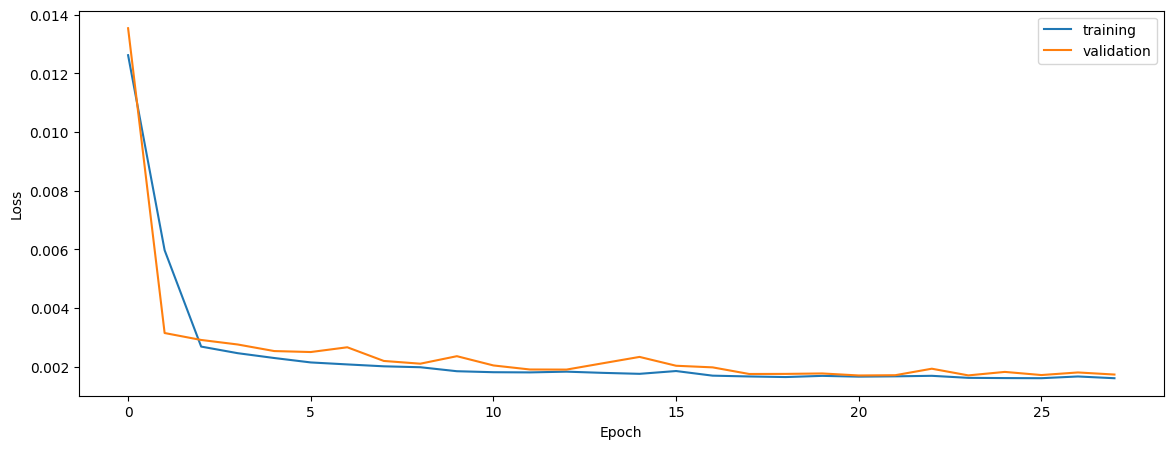

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


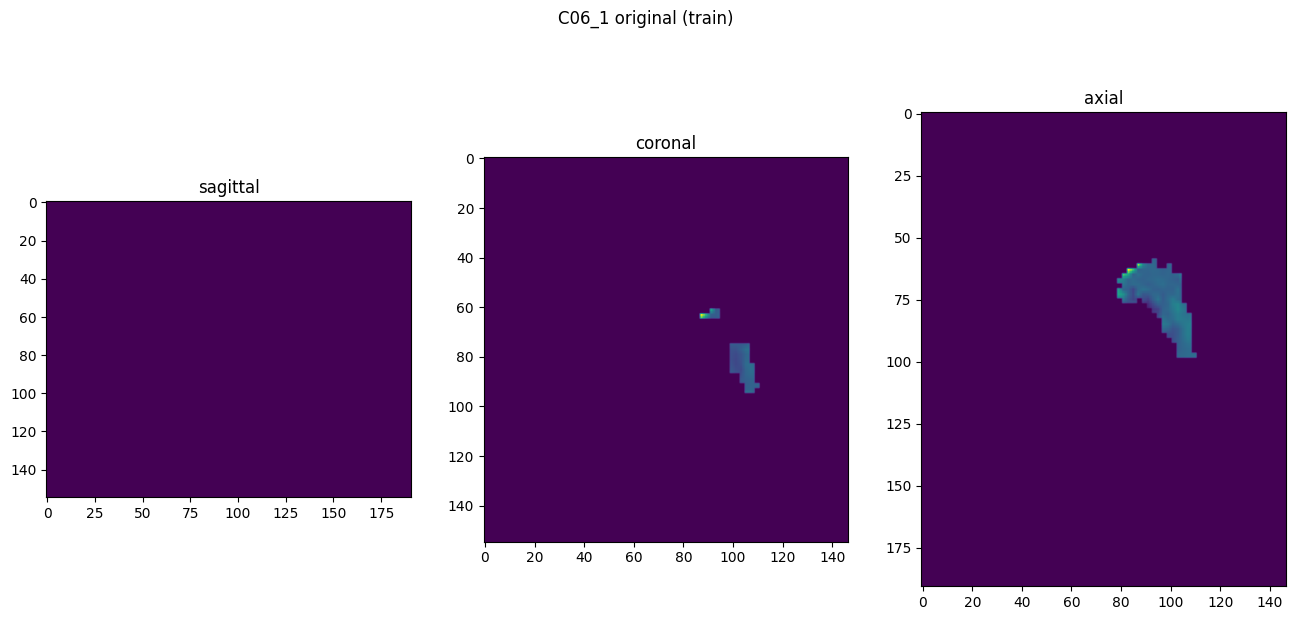

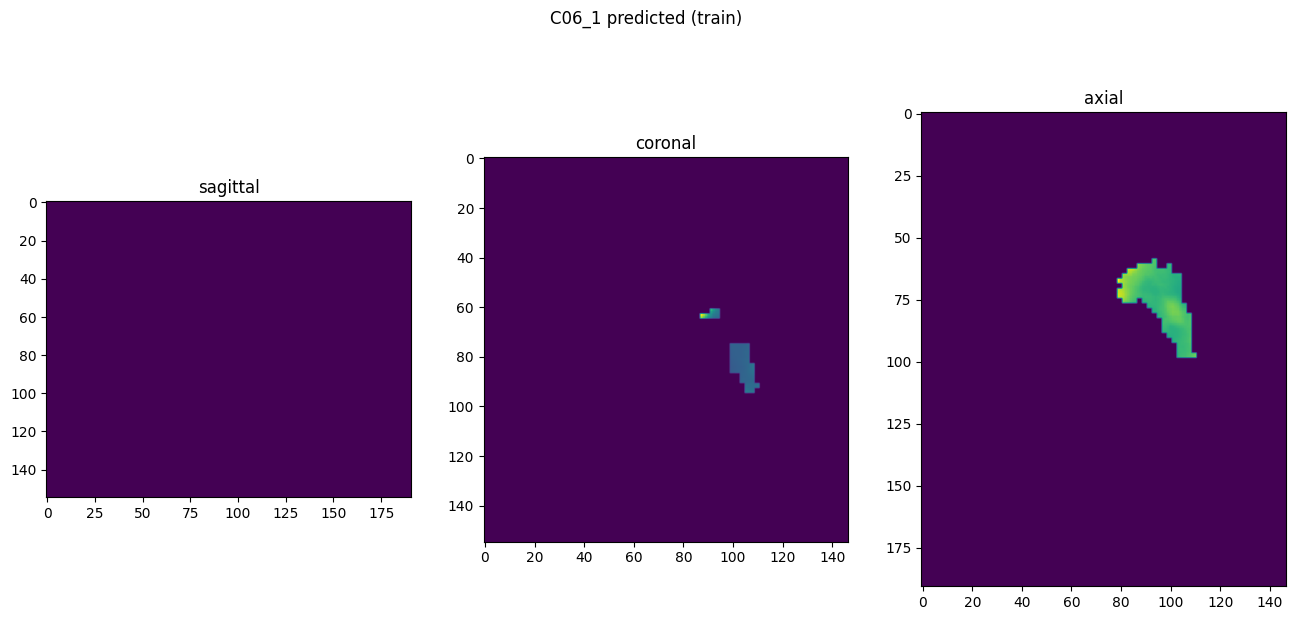

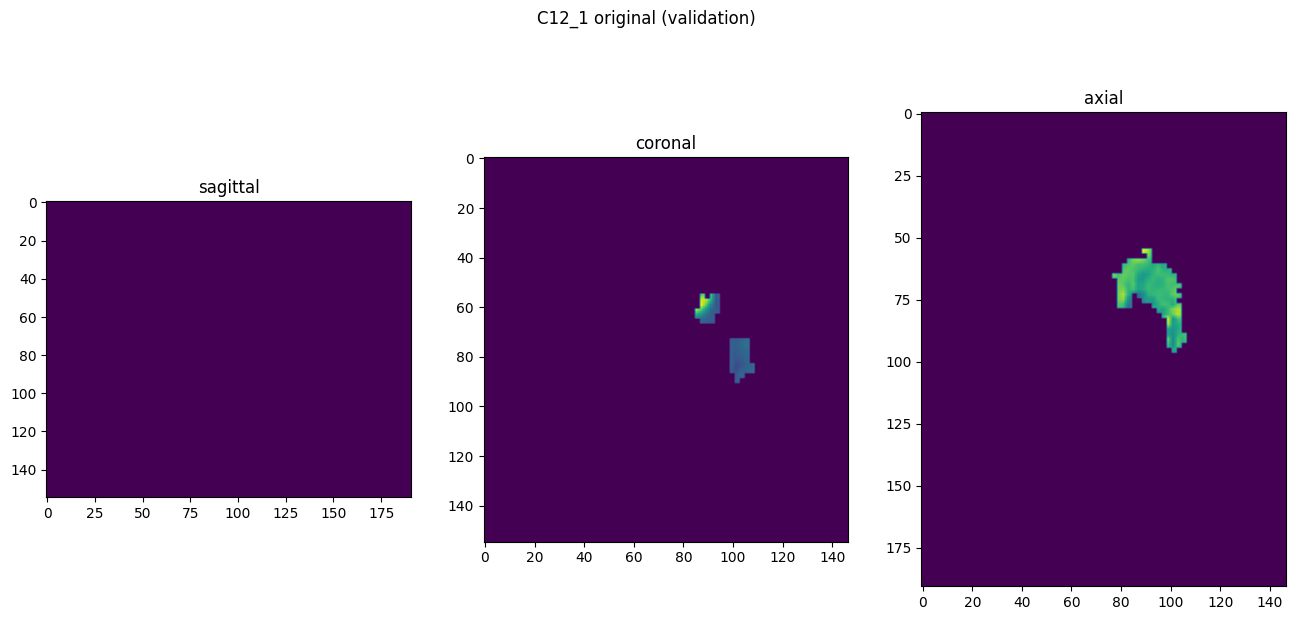

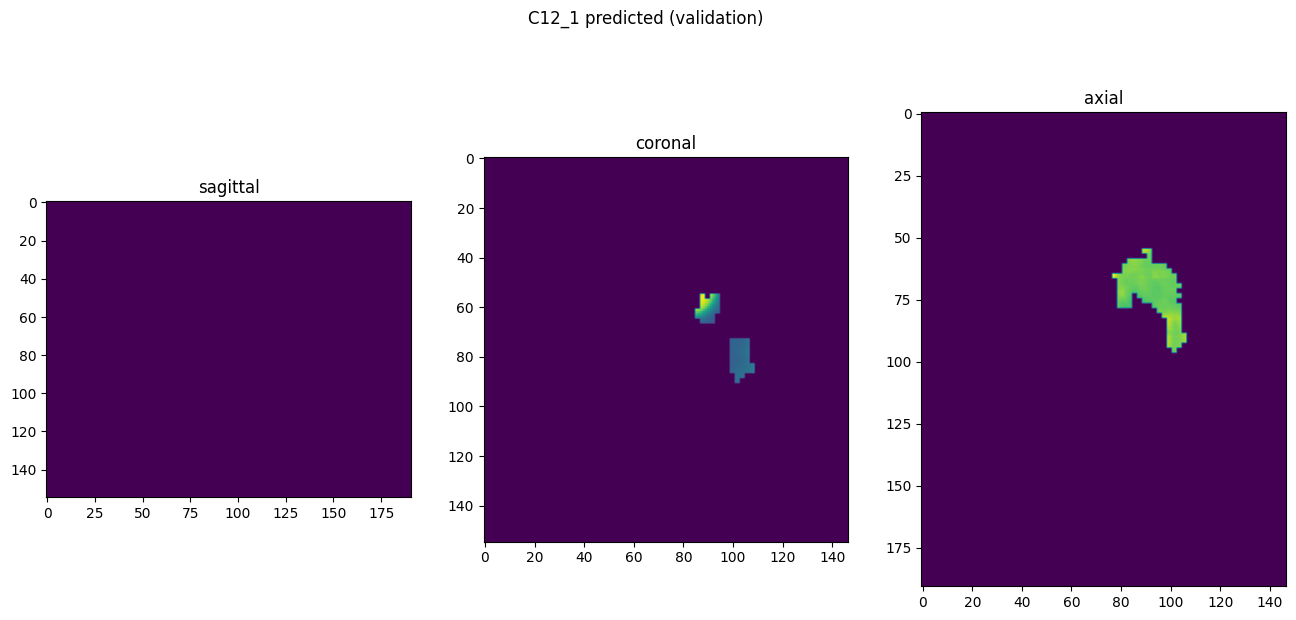

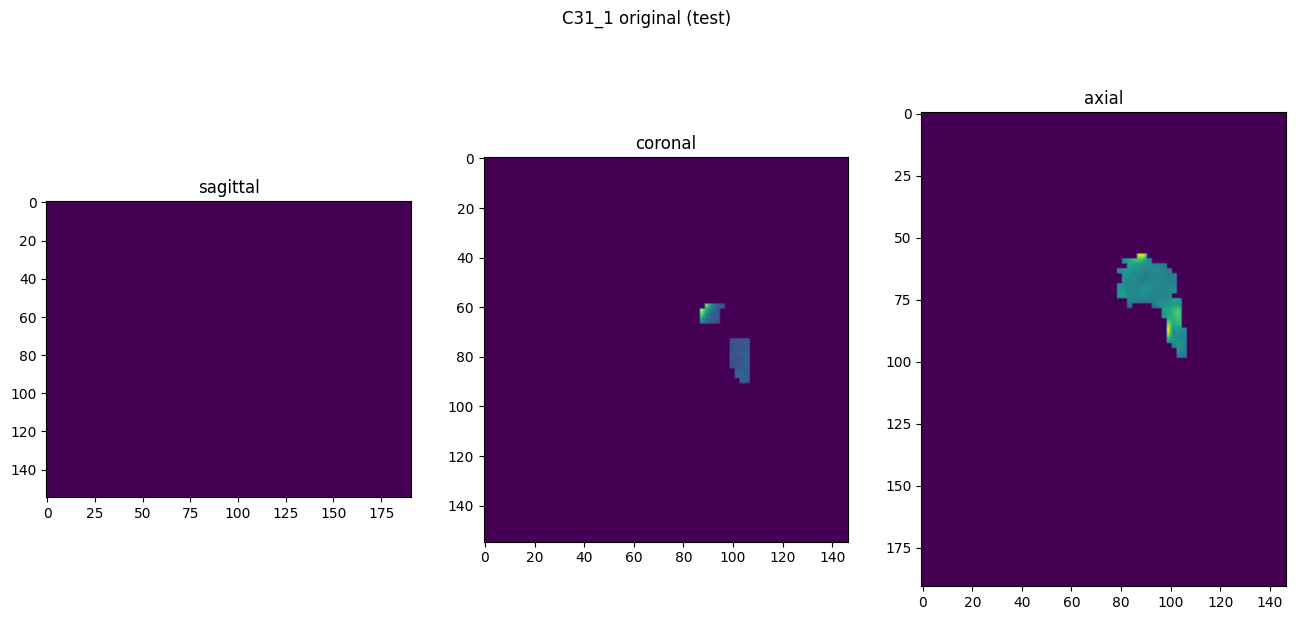

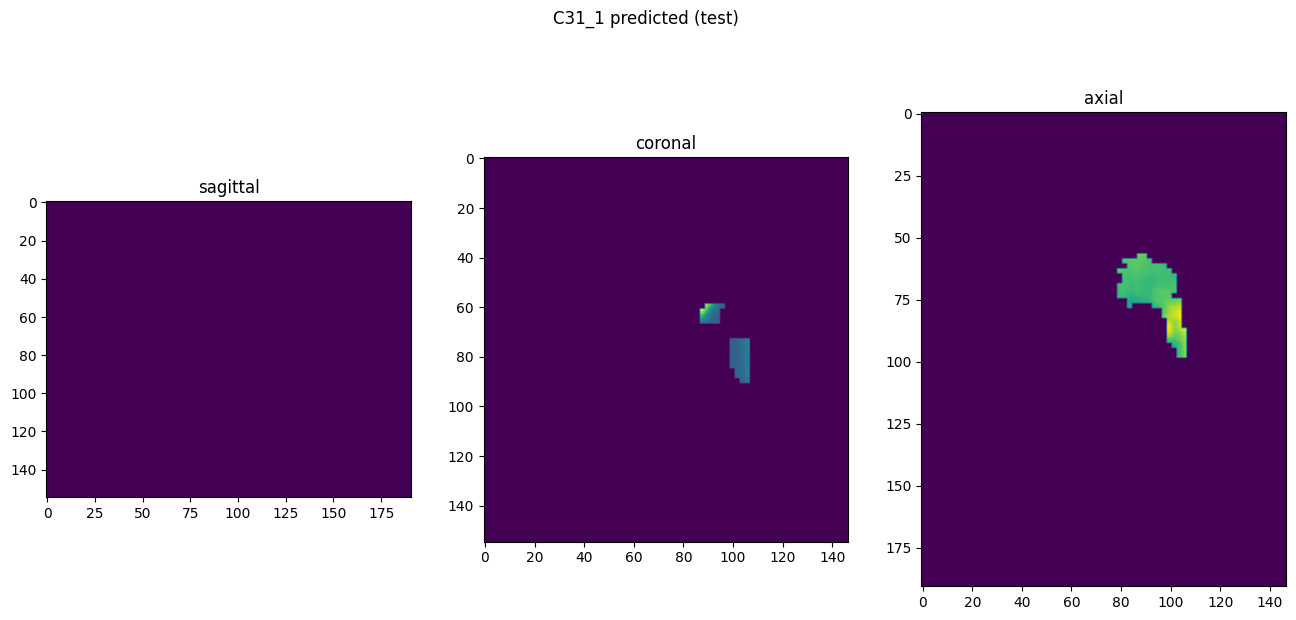

In [10]:
showResults(model, gen, threshold=None, background=False)